# DICOM RT Tool Tutorial with Open-Access Data

This notebook demonstrates the various functions and utilities avaliable in the Dicom RT tool Python package (https://github.com/brianmanderson/Dicom_RT_and_Images_to_Mask) by Anderson et. al. It serves as supplementary information for the Technical Paper titled: "Simple Python Module for Conversions between DICOM Images and Radiation Therapy Structures, Masks, and Prediction Arrays". This notebook works through an example of publically avalaible brain tumor data of T1-w/FLAIR MRI sequences and corresponding RT structure files with multiple segemented regions of interest. Full information of the publically avaliable brain tumor data used in this notebook can be found at: https://figshare.com/articles/dataset/Data_from_An_Investigation_of_Machine_Learning_Methods_in_Delta-radiomics_Feature_Analysis/9943334. This notebook was written for easy accesibility for beginners to Python programming, medical imaging, and computational analyis. It should take no more than 10-15 minutes to run in it's entirety from scratch. 

The notebook covers the following topics (click to go to section):
1. [Getting the Data](#DATA)
2. [Reading in DICOM and RT struct files and converting to numpy array format](#DICOM)
3. [Saving arrays to nifti format and reloading them](#NIFTI)
4. [Saving and loading numpy files for later use](#NUMPY)
5. [Calculating radiomic features from converted numpy arrays](#RADIOMICS)

The notebook assumes you have the following nested directory structure after running cells that download neccessary data:

In [ ]:
"""
Top-level directory/
├── DICOMRTTool_manuscript.ipynb
├── Example_Data/ <- Generated when you run the cells below
|   ├── Image_Data/ 
|       ├── Structure/ <- These correspond to the Pre-RT scans
│           ├── T1/
|               ├── Patient number (12)/
|                   ├── RT Struc file (.dcm) 
│           ├── T2FLAIR/
|               ├── Patient number (12)/
|                   ├── RT Struc file (.dcm)
|       ├── T1/
|           ├── Post1/
|               ├── Patient number (12)/
|                   ├── DICOM image files (.dcm)
|           ├── Post2/
|               ├── Patient number (12)/
|                   ├── DICOM image files (.dcm)
|           ├── Pre/
|               ├── Patient number (12)/
|                   ├── DICOM image files (.dcm) <- The images we care about
|       ├── T2FLAIR/
|           ├── Post1/
|               ├── Patient number (12)/
|                   ├── DICOM image files (.dcm)
|           ├── Post2/
|               ├── Patient number (12)/
|                   ├── DICOM image files (.dcm)
|           ├── Pre/
|               ├── Patient number (12)/
|                   ├── DICOM image files (.dcm) <- The images we care about
├── Data.zip <- Generated when you run the cells below
├── nifti/ <- Generated when you run the cells below
|   ├──Image.nii
|   ├──Mask.nii
|   ├──MRN_Path_To_Iteration.xlsx
|   ├──Overall_Data_Examples_0.0.nii.gz
|   ├──Overall_mask_Examples_y0.0.nii.gz
├── numpy/ <- Generated when you run the cells below
|   ├──image.npy
|   ├──mask.npy
"""

In [1]:
# importing neccessary libraries 

# file mangagment 
import os 
import zipfile
from six.moves import urllib

# array manipulation and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# medical image manipulation 
import SimpleITK as sitk
#from DicomRTTool.ReaderWriter import DicomReaderWriter # pip install DicomRTTool, uncomment this when PyPI is updated
import nibabel as nib
from radiomics import featureextractor # pip install pyradiomics

In [2]:
os.chdir("..") # move up one folder to access src folder, temporary solution until PyPI is updated
cwd = os.getcwd()

In [3]:
from src.DicomRTTool.ReaderWriter import DicomReaderWriter # temporary while working on latest version from github pulls

In [4]:
os.chdir("Examples") # change working directory back to what it was 
cwd = os.getcwd()

## Part 1: Getting the Data <a name="DATA"></a>

The RT struc files and their corresponding DICOM images can be in the same directory or different directories. Here we show a case where files are located in the same directory. This is a good dataset to work with since its somwhat messy but coherent enough to show power of DICOMRTTool. Many files but only pre-RT T1 and FLAIR images have assocaited RT structure files. Downloading and unzipping the neccessary files will take about 8 minutes on most CPUs and takes up about 8 GB of storage. One may visalize these DICOM images using a free commericially avaliable DICOM viewer, such as Radiant (https://www.radiantviewer.com/).

In [5]:
%%time

data_path = 'Example_Data'
if not os.path.isdir(data_path): # create Example_data directory if it doesn't exist
    os.mkdir(data_path)

url_img = "https://ndownloader.figshare.com/files/20140100" # brain scans 
filename_img = 'Example_Data/Data.zip'
if not os.path.isfile(filename_img): # if zip file doesnt exist download 
    print ("Retrieving zipped images...")
    urllib.request.urlretrieve(url_img, filename_img)
else:
    print ("Zipped images already downloaded.")


if os.path.isfile(filename_img): # if zip file exists unzip them
    print ("Unzipping images...")
    z = zipfile.ZipFile(filename_img)
    z.extractall(data_path)
    print ("Done unzipping images.")
    
print("All required files downloaded!") # print when done

Zipped images already downloaded.
Unzipping images...
Done unzipping images.
All required files downloaded!
Wall time: 3min 43s


The following is a helper function to show image outputs throughout the notebook.

In [6]:
def display_slices(image, mask, skip=1):
    """
    Displays a series of slices that contains the segmented regions of interest.
    Ensures all contours are displayed in consistent and different colors.
        Parameters:
            image (array-like): numpy array of image 
            mask (array-like): numpy array of mask
            skip (int): Only prenth every nth slice, i.e. if 3 only print every 3rd slice, default 1.
        Returns:
            None (series of in-line plots)
    """

    slice_locations = np.unique(np.where(mask != 0)[0]) # get indexes for where there is a contour present 
    slice_start = slice_locations[0] # first slice of contour 
    slice_end = slice_locations[len(slice_locations)-1] # last slice of contour
    
    counter = 1
    
    for img_arr, contour_arr in zip(image[slice_start:slice_end+1], mask[slice_start:slice_end+1]): # plot the slices with contours overlayed ontop
        if counter % skip == 0: # if current slice is divisible by desired skip amount 
            masked_contour_arr = np.ma.masked_where(contour_arr == 0, contour_arr)
            plt.imshow(img_arr, cmap='gray', interpolation='none')
            plt.imshow(masked_contour_arr, cmap='cool', interpolation='none', alpha=0.5, vmin = 1, vmax = np.amax(mask)) # vmax is set as total number of contours so same colors can be displayed for each slice
            plt.show()
        counter += 1

## Part 2: Reading in DICOM and RT struct files and converting to numpy array format. <a name="DICOM"></a>

The principal on which these set of tools operates on is based on the DicomReaderWriter object. It is instantiated with the contours of interest (and associations) and can then be used to create numpy arrays of images and masks of the format [slices, width, height].


The following code logic is used to demonstrate searching a path to return indexes for matched structures with their images by UID pairs for arbitrary directory structures (DICOM image files and RT Struct files not in the same folder). If all neccessary structure files are in the same folder as the corresponding images (by UID), one can alternativley use an os.walk through directories of interest. For example, I normally use a folder structure MRN -> date of image (pre,mid,post-RT) -> type of scan (MRI, CT, etc.) -> files (DICOM images + RT Struct). However, this approach calls the DicomReaderWriter iterativley, which can be computationally taxing.

In [7]:
DICOM_path = os.path.join('.', 'Example_Data\\Image_Data') # folder where downloaded data was stored

In [8]:
print(DICOM_path)

.\Example_Data\Image_Data


In [9]:
%%time
Dicom_reader = DicomReaderWriter(description='Examples', arg_max=True)
Dicom_reader.walk_through_folders(DICOM_path) # need to define in order to use all_roi method

Index 0, description ax T1 3D 1MM fSPGR +C  at .\Example_Data\Image_Data\T1\Pre\001
Index 1, description ax T1 3D 1MM fSPGR +C  at .\Example_Data\Image_Data\T1\Pre\002
Index 2, description ax T1 3D 1MM fSPGR +C  at .\Example_Data\Image_Data\T1\Pre\003
Index 3, description ax T1 3D 1MM fSPGR +C  at .\Example_Data\Image_Data\T1\Pre\004
Index 4, description ax T1 3D 1MM fSPGR +C  at .\Example_Data\Image_Data\T1\Pre\005
Index 5, description ax T1 3D 1MM fSPGR +C  at .\Example_Data\Image_Data\T1\Pre\006
Index 6, description ax T1 3D 1MM fSPGR +C  at .\Example_Data\Image_Data\T1\Pre\007
Index 7, description ax T1 3D 1MM  +c at .\Example_Data\Image_Data\T1\Pre\008
Index 8, description None at None
Index 9, description ax T1 3D 1MM  +c at .\Example_Data\Image_Data\T1\Pre\010
Index 10, description ax T1 3D 1MM  +c at .\Example_Data\Image_Data\T1\Pre\011
Index 11, description ax T1 3D 1MM  +c at .\Example_Data\Image_Data\T1\Pre\012
Index 12, description Ax T2Flair Propeller at .\Example_Data\Ima

Interating through all the folders and files we find 73 usable image/structure pairs, each given a unique index.

In [10]:
all_rois = Dicom_reader.return_rois(print_rois=True)  # Return a list of all rois present, and print them

The following ROIs were found
exprtfrontrecgli
rtfrontrecglioma
brainstem1
dose 500[cgy]
dose 1200[cgy]
dose 1000[cgy]
body
gtvplus2
exprttempglioma
rttempglioma
brainstem
exprtfrontrecgbm
rtfrontrecgbm
explttempglioma
lttempglioma
dose 2400[cgy]
expltfrontgbm
ltfrontgbm
eye, left
lens, right
lens, left
ltparrecglioma
chiasm
optic nerve, rig
optic nerve, lef
expltparrecgliom
eye, right
expltfrontrecao
ltfrontrecao
dose 2500[cgy]
rttemprecglioma
exprttemprecglio
ltfrparrecgbm
expltfrparrecgbm
expinfrttemprecg
infrttempgbm
rttemprecgbm
exprttemprecgbm
exprtfrparresxn
right_front_par_
abv
abv_roi


In [11]:
Contour_Names = ['brainstem', 'dose 1200[cgy]', 'gtvplus2'] 

associations = {'brainstem1':'brainstem', # just to show an example of how associations works
               'dose 1000[cgy]': 'dose 1200[cgy]'} # assume you want the 1000 cgy ROI to be considered same as 1200 cgy ROI

In [12]:
Dicom_reader.set_contour_names(Contour_Names)
Dicom_reader.__set_associations__(associations)

Lacking ['brainstem'] in index 0, location .\Example_Data\Image_Data\T1\Pre\001. Found ['exprtfrontrecgli', 'rtfrontrecglioma', 'brainstem1', 'dose 500[cgy]', 'dose 1200[cgy]', 'dose 1000[cgy]', 'body', 'gtvplus2']
Lacking ['brainstem'] in index 10, location .\Example_Data\Image_Data\T1\Pre\011. Found ['rttemprecgbm', 'exprttemprecgbm', 'brainstem1', 'dose 500[cgy]', 'dose 1000[cgy]', 'dose 1200[cgy]', 'body', 'gtvplus2']
Lacking ['brainstem'] in index 12, location .\Example_Data\Image_Data\T2Flair\Pre\001. Found ['rtfrontrecglioma', 'exprtfrontrecgli', 'brainstem1', 'dose 1000[cgy]', 'dose 1200[cgy]', 'dose 500[cgy]', 'gtvplus2']
Lacking ['brainstem'] in index 22, location .\Example_Data\Image_Data\T2Flair\Pre\011. Found ['brainstem1', 'dose 1000[cgy]', 'dose 1200[cgy]', 'dose 500[cgy]', 'exprttemprecgbm', 'rttemprecgbm', 'body', 'gtvplus2']
Lacking ['brainstem', 'dose 1200[cgy]', 'gtvplus2'] in index 24, location .\Example_Data\Image_Data\T1\Post1\001. Found []
Lacking ['brainstem', 

Note: The module is printing "Found []" because many of the scans (post-1 and post-2 RT) do not have associated structure files. The module recognizes these images exist (unique UIDs) but not associated structure files can be located for them.

In [13]:
Dicom_reader.set_index(11)  # Setting to 11 since this index has all the structures, corresponds to T1-w image for patient 12
Dicom_reader.get_images_and_mask()  # Load up the images and mask for the requested index

Loading images for ax T1 3D 1MM  +c at 
 .\Example_Data\Image_Data\T1\Pre\012



In [14]:
image = Dicom_reader.ArrayDicom # image array
mask = Dicom_reader.mask # mask array

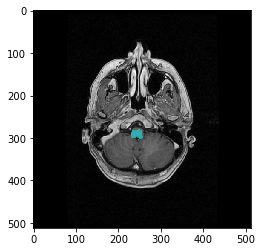

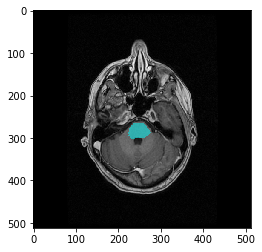

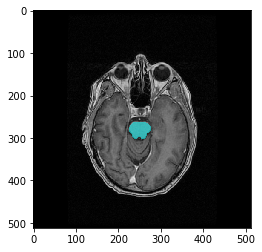

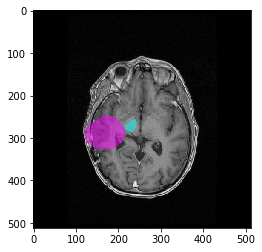

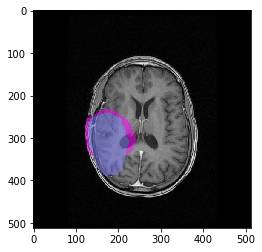

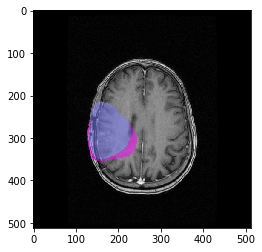

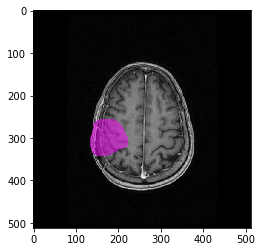

In [15]:
display_slices(image, mask, skip = 15) # visualize that our segmentations were succesfully convereted 

Note: Cyan color denotes brainstem, lavender denotes dose, magenta denotes tumor.

## Part 3: Saving arrays to nifti format. <a name="NIFTI"></a>

If you want to use a manual approach, you can view the nifti files easily after running get_images_and_mask()

In [16]:
nifti_path = os.path.join('.', 'nifti') # go into nifti subfolder 
if not os.path.exists(nifti_path):
    os.makedirs(nifti_path)

In [17]:
dicom_sitk_handle = Dicom_reader.dicom_handle
mask_sitk_handle = Dicom_reader.annotation_handle
sitk.WriteImage(dicom_sitk_handle, os.path.join(nifti_path, 'Image.nii'))
sitk.WriteImage(mask_sitk_handle, os.path.join(nifti_path, 'Mask.nii'))

Note the nifti writer creates a log .txt file in each DICOM folder and a corresponding log excel file in the specified output path.

In [18]:
%%time
Dicom_reader.write_parallel(out_path = nifti_path, excel_file = os.path.join(nifti_path,'.','MRN_Path_To_Iteration.xlsx'))

Lacking ['brainstem', 'dose 1200[cgy]', 'gtvplus2'] in index 24, location .\Example_Data\Image_Data\T1\Post1\001. Found []
Lacking ['brainstem', 'dose 1200[cgy]', 'gtvplus2'] in index 25, location .\Example_Data\Image_Data\T1\Post1\002. Found []
Lacking ['brainstem', 'dose 1200[cgy]', 'gtvplus2'] in index 26, location .\Example_Data\Image_Data\T1\Post1\003. Found []
Lacking ['brainstem', 'dose 1200[cgy]', 'gtvplus2'] in index 27, location .\Example_Data\Image_Data\T1\Post1\004. Found []
Lacking ['brainstem', 'dose 1200[cgy]', 'gtvplus2'] in index 28, location .\Example_Data\Image_Data\T1\Post1\005. Found []
Lacking ['brainstem', 'dose 1200[cgy]', 'gtvplus2'] in index 29, location .\Example_Data\Image_Data\T1\Post1\006. Found []
Lacking ['brainstem', 'dose 1200[cgy]', 'gtvplus2'] in index 30, location .\Example_Data\Image_Data\T1\Post1\007. Found []
Lacking ['brainstem', 'dose 1200[cgy]', 'gtvplus2'] in index 31, location .\Example_Data\Image_Data\T1\Post1\008. Found []
Lacking ['brains

In [19]:
nifti_image = nib.load(os.path.join(nifti_path,"Overall_Data_Examples_0.0.nii.gz")) # reload image
image = np.array(nifti_image.dataobj)
image = np.moveaxis(image,-1,0) # have to swap axis because nifti files orient patient differently 
image = np.swapaxes(image, 1, 2)

nifti_mask = nib.load(os.path.join(nifti_path,"Overall_mask_Examples_y0.0.nii.gz")) # reload mask
mask = np.array(nifti_mask.dataobj)
mask = np.moveaxis(mask,-1,0) # have to swap axis because nifti files orient patient differently 
mask = np.swapaxes(mask, 1, 2)

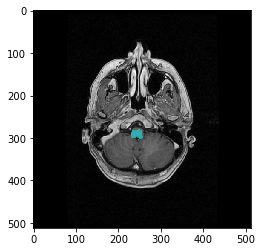

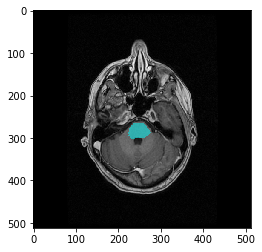

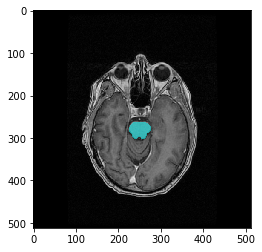

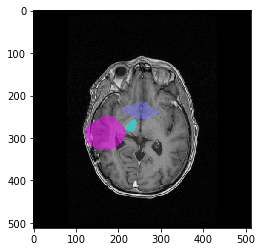

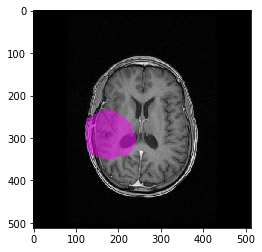

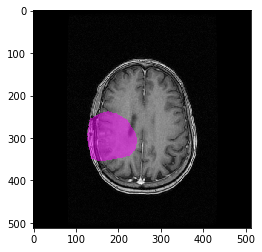

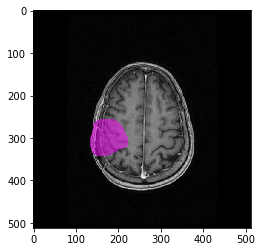

In [20]:
display_slices(image, mask, skip = 15) # visualize that our segmentations were succesfully convereted from nifti 

## Part 4: Saving and loading numpy files for later use. <a name="NUMPY"></a>

Finally we can save the numpy arrays to files for later use (so you don't have to reinstantiate the computationally expensive DicomReaderWriter object) and subsequently re-load the numpy arrays. It is however advisable to load in arrays from nifti format, since spacing and other important properties are preserved in nifti format but NOT numpy array format.

In [21]:
numpy_path = os.path.join('.', 'numpy') # go into numpy subfolder 
if not os.path.exists(numpy_path):
    os.makedirs(numpy_path)

In [22]:
np.save(os.path.join(numpy_path,'image'), image) # save the arrays
np.save(os.path.join(numpy_path,'mask'), mask)

In [23]:
image = np.load(os.path.join(numpy_path,'image.npy')) # load the arrays
mask = np.load(os.path.join(numpy_path,'mask.npy'))

## Part 5: Radiomics Use-case Example <a name="RADIOMICS"></a>

Here we use the popular open-source radiomics library PyRadiomics (https://pyradiomics.readthedocs.io/en/latest/) to calculate radiomic features for our ROIs. In this case, we only calculate a limited number features from the tumor as an illustrative example. 

In [24]:
def convert_array(array, index):
    """
    Creates a masked array specific for a given ROI index. 
        Parameters:
            array (np array): Input array corresponding to all masks superimposed on image.
            index (int): Index to mask with respect to, i.e. only select cetain sub-mask.
        Returns:
            array_new (np array): Output masked array.
    """
    array_new = array.copy() # must create copy or else changes original 
    array_new[array_new!=index] = 0
    array_new[array_new==index] = 1
    return array_new

In [25]:
%%time
mask_new = convert_array(mask,3) # only consider mask for GTV (index 3)

sitk_img = sitk.GetImageFromArray(image) # need sitk image to plug into PyRadiomics
sitk_mask = sitk.GetImageFromArray(mask_new) 

params = {} # can edit in more params as neccessary 
extractor = featureextractor.RadiomicsFeatureExtractor(**params) # instantiate extractor with parameters 
extractor.disableAllFeatures() # in case where only want some features, can delete these lines if you want deafult
extractor.enableFeatureClassByName('firstorder') 
extractor.enableFeatureClassByName('glcm') 
features = {} # empty dictionary 
features = extractor.execute(sitk_img, sitk_mask) # unpack results into features dictionary
df = pd.DataFrame({k: [v] for k, v in features.items()}) # put dictionary into a dataframe 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Wall time: 9.26 s


In [26]:
df

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_MCC,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glcm_SumSquares
0,v3.0,1.18.5,1.2.4,1.1.1,3.7.6,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},5ca78310b63a09127f158bf314f87c904aafce26,3D,"(1.0, 1.0, 1.0)",...,0.9702775748023973,0.35274703690842835,31.169518899121744,0.003960471210610121,9.122966797084493,0.8911175790432286,0.013685552483753591,62.33903779824347,6.25205377288367,111.36612219806499


Numerical results are consistent with 3D Slicer (https://www.slicer.org/) using Radiomics (https://www.slicer.org/wiki/Documentation/Nightly/Extensions/Radiomics) extension.  